<a href="https://colab.research.google.com/github/seharnazeer/Python--projects/blob/main/cart_id3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [5]:
X=pd.DataFrame(load_iris().data, columns=load_iris().feature_names)
y=pd.DataFrame(load_iris().target, columns=["species"])

In [6]:
X.head() , y

(   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                5.1               3.5                1.4               0.2
 1                4.9               3.0                1.4               0.2
 2                4.7               3.2                1.3               0.2
 3                4.6               3.1                1.5               0.2
 4                5.0               3.6                1.4               0.2,
      species
 0          0
 1          0
 2          0
 3          0
 4          0
 ..       ...
 145        2
 146        2
 147        2
 148        2
 149        2
 
 [150 rows x 1 columns])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(X_column, y):
    """Calculate information gain for a feature"""
    total_entropy = entropy(y)

    values, counts = np.unique(X_column, return_counts=True)

    print("Unique Values:", values)  # Debugging Step
    print("Counts:", counts)  # Debugging Step

    # Compute weighted entropy
    weighted_entropy = sum(
        (counts[i] / len(X_column)) * entropy(y[X_column == values[i]])
        for i in range(len(values))  # ✅ FIX: Use len(values)
    )

    return total_entropy - weighted_entropy

# Test Information Gain Calculation
print("Entropy of Training Labels:", entropy(y_train))
print("Information Gain for Sepal Length:", information_gain(X_train["sepal length (cm)"], y_train))


Entropy of Training Labels: 1.5846619079379884
Unique Values: [4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.
 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.6 7.7]
Counts: [1 3 1 4 1 2 5 9 8 4 1 5 6 4 6 6 3 5 4 3 8 5 3 2 6 1 3 1 1 3 1 1 1 3]
Information Gain for Sepal Length: 0.8779105326909196


In [10]:
def best_split(X, y):
    """Find the best feature and threshold to split on"""
    best_gain = -1
    best_feature = None
    best_threshold = None

    for feature in X.columns:
        sorted_values = np.sort(X[feature].unique())

        # Compute midpoints as potential thresholds
        thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2

        for threshold in thresholds:
            left_mask = X[feature] <= threshold
            right_mask = X[feature] > threshold

            left_entropy = entropy(y[left_mask])
            right_entropy = entropy(y[right_mask])

            weighted_entropy = ((sum(left_mask) * left_entropy) + (sum(right_mask) * right_entropy)) / len(y)
            gain = entropy(y) - weighted_entropy

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

# Test Threshold-based Splitting
best_feature, best_threshold = best_split(X_train, y_train)
print("Best Feature:", best_feature, "Best Threshold:", best_threshold)


Best Feature: petal length (cm) Best Threshold: 2.45


In [11]:
def build_tree(X, y, depth=0, max_depth=3):
    """Recursively build the decision tree"""

    # Convert y to a 1D NumPy array
    y = y.to_numpy().flatten()

    # Base case: If all labels are the same, return that label
    if len(np.unique(y)) == 1:
        return np.unique(y)[0]

    # Base case: If max depth is reached, return the most common label
    if depth >= max_depth:
        return np.bincount(y.astype(int)).argmax()

    # Find best feature and threshold
    best_feature, best_threshold = best_split(X, y)
    if best_feature is None:
        return np.bincount(y.astype(int)).argmax()

    # Create subtree
    tree = {f"{best_feature} <= {best_threshold}": {}}

    # Split dataset using threshold
    left_mask = X[best_feature] <= best_threshold
    right_mask = X[best_feature] > best_threshold

    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]

    # Recursive calls for left and right nodes
    tree[f"{best_feature} <= {best_threshold}"]["left"] = (
        build_tree(X_left, pd.Series(y_left), depth + 1, max_depth) if len(y_left) > 0 else np.bincount(y.astype(int)).argmax()
    )
    tree[f"{best_feature} <= {best_threshold}"]["right"] = (
        build_tree(X_right, pd.Series(y_right), depth + 1, max_depth) if len(y_right) > 0 else np.bincount(y.astype(int)).argmax()
    )

    return tree

# Test Tree Building
tree = build_tree(X_train, y_train, max_depth=3)
print("Fixed Decision Tree Structure:", tree)


Fixed Decision Tree Structure: {'petal length (cm) <= 2.45': {'left': 0, 'right': {'petal length (cm) <= 4.75': {'left': {'petal width (cm) <= 1.65': {'left': 1, 'right': 2}}, 'right': {'petal width (cm) <= 1.75': {'left': 1, 'right': 2}}}}}}


In [15]:
def predict_single(x, tree):
    """Recursively predict for a single sample"""
    if not isinstance(tree, dict):
        return tree  # If it's a leaf node, return the class label

    feature_condition = list(tree.keys())[0]  # Example: "PetalLengthCm <= 2.45"
    feature, _ , threshold = feature_condition.split()
    feature = feature.strip()  # Ensure no spaces
    threshold = float(threshold)  # Convert to number

    # Traverse the tree
    if x[feature] <= threshold:
        return predict_single(x, tree[feature_condition]["left"])
    else:
        return predict_single(x, tree[feature_condition]["right"])

def predict(X, tree):
    """Predict for multiple samples"""
    return np.array([predict_single(X.iloc[i], tree) for i in range(len(X))])

# Predict on test data
y_pred = predict(X_test, tree)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print("ID3 Decision Tree Accuracy:", accuracy)


ValueError: too many values to unpack (expected 3)

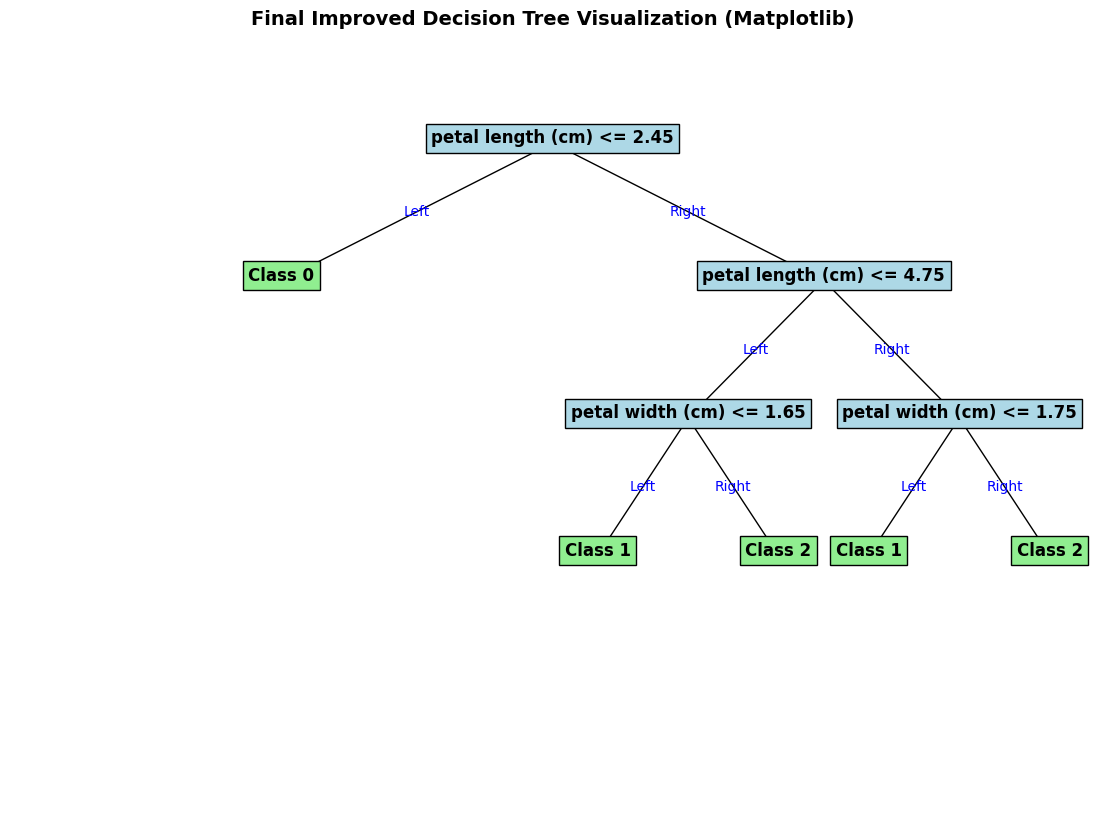

In [17]:
import matplotlib.pyplot as plt

def plot_custom_tree(tree, x=0, y=0, level=1, dx=6, dy=2.5, ax=None, parent=None, edge_label=""):
    """ Recursively plot the decision tree using matplotlib. """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 10))  # Bigger size for better spacing
        ax.set_xlim(-12, 12)
        ax.set_ylim(-12, 2)
        ax.axis("off")  # Hide axes

    if isinstance(tree, dict):
        feature_condition = list(tree.keys())[0]

        # Add decision node
        ax.text(x, y, feature_condition, ha="center", fontsize=12, fontweight="bold",
                bbox=dict(facecolor="lightblue", edgecolor="black"))

        children = list(tree[feature_condition].items())

        left_x, left_y = x - dx / level, y - dy  # Move left
        right_x, right_y = x + dx / level, y - dy  # Move right

        # Draw edges with labels
        ax.plot([x, left_x], [y, left_y], 'k-', lw=1)
        ax.plot([x, right_x], [y, right_y], 'k-', lw=1)

        # **Improved Edge Labels**
        ax.text((x + left_x) / 2, (y + left_y) / 2, "Left", fontsize=10, ha="center", va="center", color="blue")
        ax.text((x + right_x) / 2, (y + right_y) / 2, "Right", fontsize=10, ha="center", va="center", color="blue")

        # Recursive calls for left and right children
        plot_custom_tree(children[0][1], left_x, left_y, level + 1, dx, dy, ax, x, "left")
        plot_custom_tree(children[1][1], right_x, right_y, level + 1, dx, dy, ax, x, "right")

    else:  # Leaf node (class label)
        ax.text(x, y, f"Class {tree}", ha="center", fontsize=12, fontweight="bold",
                bbox=dict(facecolor="lightgreen", edgecolor="black"))

    return ax

# Plot the final improved tree
plot_custom_tree(tree)
plt.title("Final Improved Decision Tree Visualization (Matplotlib)", fontsize=14, fontweight="bold")
plt.show()


In [24]:
def gini_index(y):
    """Calculate Gini Index for a given set of labels y"""
    if len(y) == 0:  # Handle empty splits
        return 0
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)
    gini = 1 - sum((count / total) ** 2 for count in counts)
    return gini


In [25]:
def gini_split(X, y):
    """Find the best feature and threshold to split the dataset using Gini Index."""
    best_feature, best_threshold = None, None
    best_gini = float("inf")

    for feature in X.columns:
        thresholds = X[feature].unique()
        for threshold in thresholds:
            left_mask = X[feature] <= threshold
            right_mask = X[feature] > threshold

            if sum(left_mask) == 0 or sum(right_mask) == 0:
                continue  # Skip if split creates an empty set

            gini_left = gini_index(y[left_mask])
            gini_right = gini_index(y[right_mask])

            weighted_gini = (sum(left_mask) / len(y)) * gini_left + (sum(right_mask) / len(y)) * gini_right

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_feature, best_threshold = feature, threshold

    return best_feature, best_threshold


In [26]:
def build_cart_tree(X, y, depth=0, max_depth=5):
    """Builds a decision tree using the CART algorithm (binary splits)."""
    if len(np.unique(y)) == 1:  # Pure node (only one class)
        return np.unique(y)[0]

    if depth >= max_depth or len(y) < 2:
        return y.value_counts().idxmax()  # Return majority class if depth limit is reached

    best_feature, best_threshold = gini_split(X, y)

    if best_feature is None:
        return y.value_counts().idxmax()  # If no valid split, return majority class

    left_mask = X[best_feature] <= best_threshold
    right_mask = X[best_feature] > best_threshold

    left_subtree = build_cart_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_cart_tree(X[right_mask], y[right_mask], depth + 1, max_depth)

    return {f"{best_feature} <= {best_threshold}": {"left": left_subtree, "right": right_subtree}}


In [27]:
cart_tree = build_cart_tree(X_train, y_train, max_depth=5)

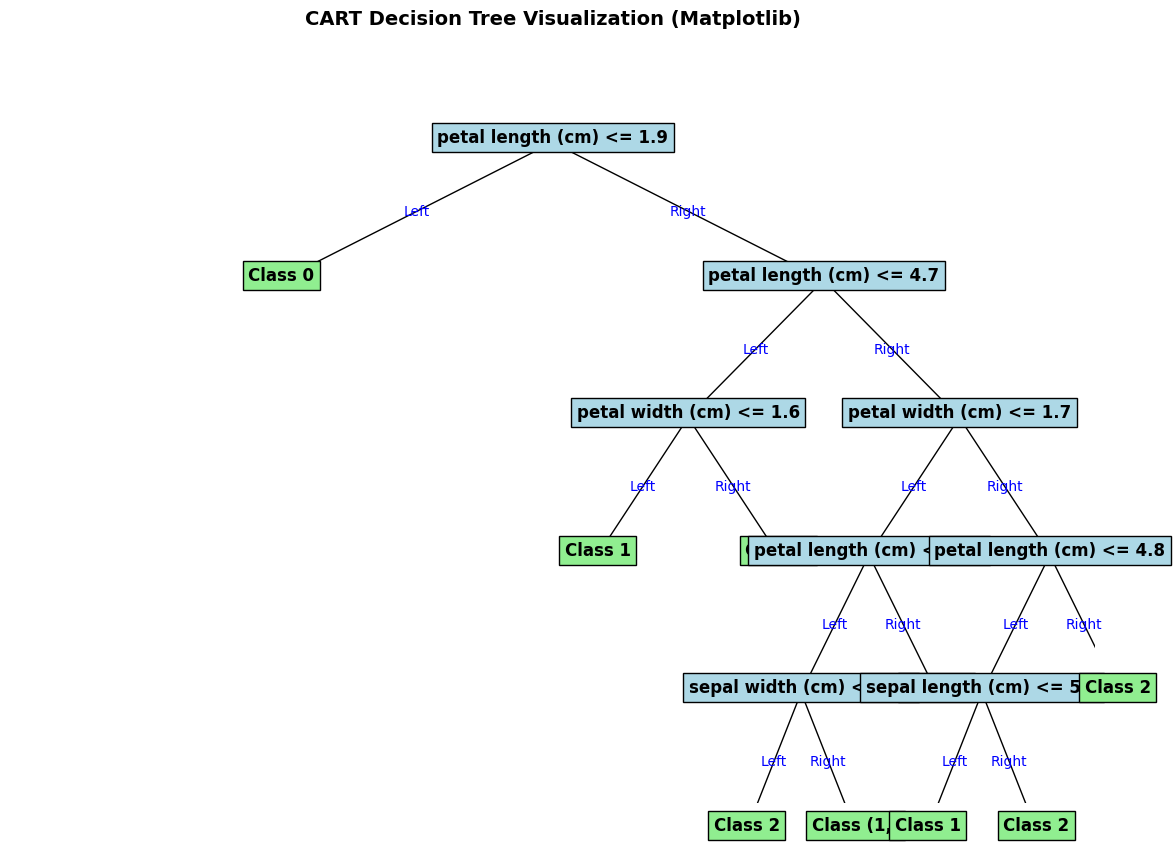

In [28]:
plot_custom_tree(cart_tree)
plt.title("CART Decision Tree Visualization (Matplotlib)", fontsize=14, fontweight="bold")
plt.show()